In [3]:
# !pip3 install torch torchvision torchaudio
# !pip3 install matplotlib
# !pip3 install soundfile

  Using cached torch-2.5.1-cp312-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached torchvision-0.20.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.5.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached setuptools-75.6.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached numpy-2.2.1-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pillow-11.0.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-macosx_11_0_arm64.whl.

In [95]:
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
import IPython.display
import soundfile as sf
import pandas

torch.random.manual_seed(0)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [99]:
torchaudio.__version__,torch.__version__,pandas.__version__

NameError: name 'pandas' is not defined

In [5]:
SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
IPython.display.Audio(SPEECH_FILE)

In [29]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)

In [8]:
bundle.get_labels

<bound method Wav2Vec2ASRBundle.get_labels of Wav2Vec2ASRBundle(_path='wav2vec2_fairseq_base_ls960_asr_ls960.pth', _params={'extractor_mode': 'group_norm', 'extractor_conv_layer_config': [(512, 10, 5), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 2, 2), (512, 2, 2)], 'extractor_conv_bias': False, 'encoder_embed_dim': 768, 'encoder_projection_dropout': 0.1, 'encoder_pos_conv_kernel': 128, 'encoder_pos_conv_groups': 16, 'encoder_num_layers': 12, 'encoder_num_heads': 12, 'encoder_attention_dropout': 0.1, 'encoder_ff_interm_features': 3072, 'encoder_ff_interm_dropout': 0.0, 'encoder_dropout': 0.1, 'encoder_layer_norm_first': False, 'encoder_layer_drop': 0.05, 'aux_num_out': 29}, _sample_rate=16000, _normalize_waveform=False, _model_type='Wav2Vec2', _labels=('|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z'), _remove_aux_axis=(1, 2, 3))>

In [7]:
audio_input, sample_rate = sf.read("/Users/deependra/.cache/torch/hub/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
audio_input.shape,sample_rate

In [75]:
# waveform,sample_rate = torchaudio.load(SPEECH_FILE)
waveform,sample_rate = torchaudio.load("/Users/deependra/work/ML/SampleDockerPush/preamble10.wav")
waveform.shape, sample_rate

(torch.Size([1, 211660]), 22050)

In [23]:
type(waveform)

torch.Tensor

In [25]:
waveform = waveform.to(device)

In [57]:
waveform.shape

torch.Size([1, 54400])

In [27]:
type(waveform)

torch.Tensor

In [76]:
if sample_rate != bundle.sample_rate:
    waveformm=torchaudio.functional.resample(waveform,sample_rate,bundle.sample_rate)

In [77]:
waveform.shape

torch.Size([1, 211660])

In [78]:
with torch.inference_mode():
    features,_ = model.extract_features(waveform)

In [62]:
features[0].shape

torch.Size([1, 169, 768])

In [90]:
type(sample_rate)

int

In [45]:
features[0].cpu()[0].shape

torch.Size([169, 768])

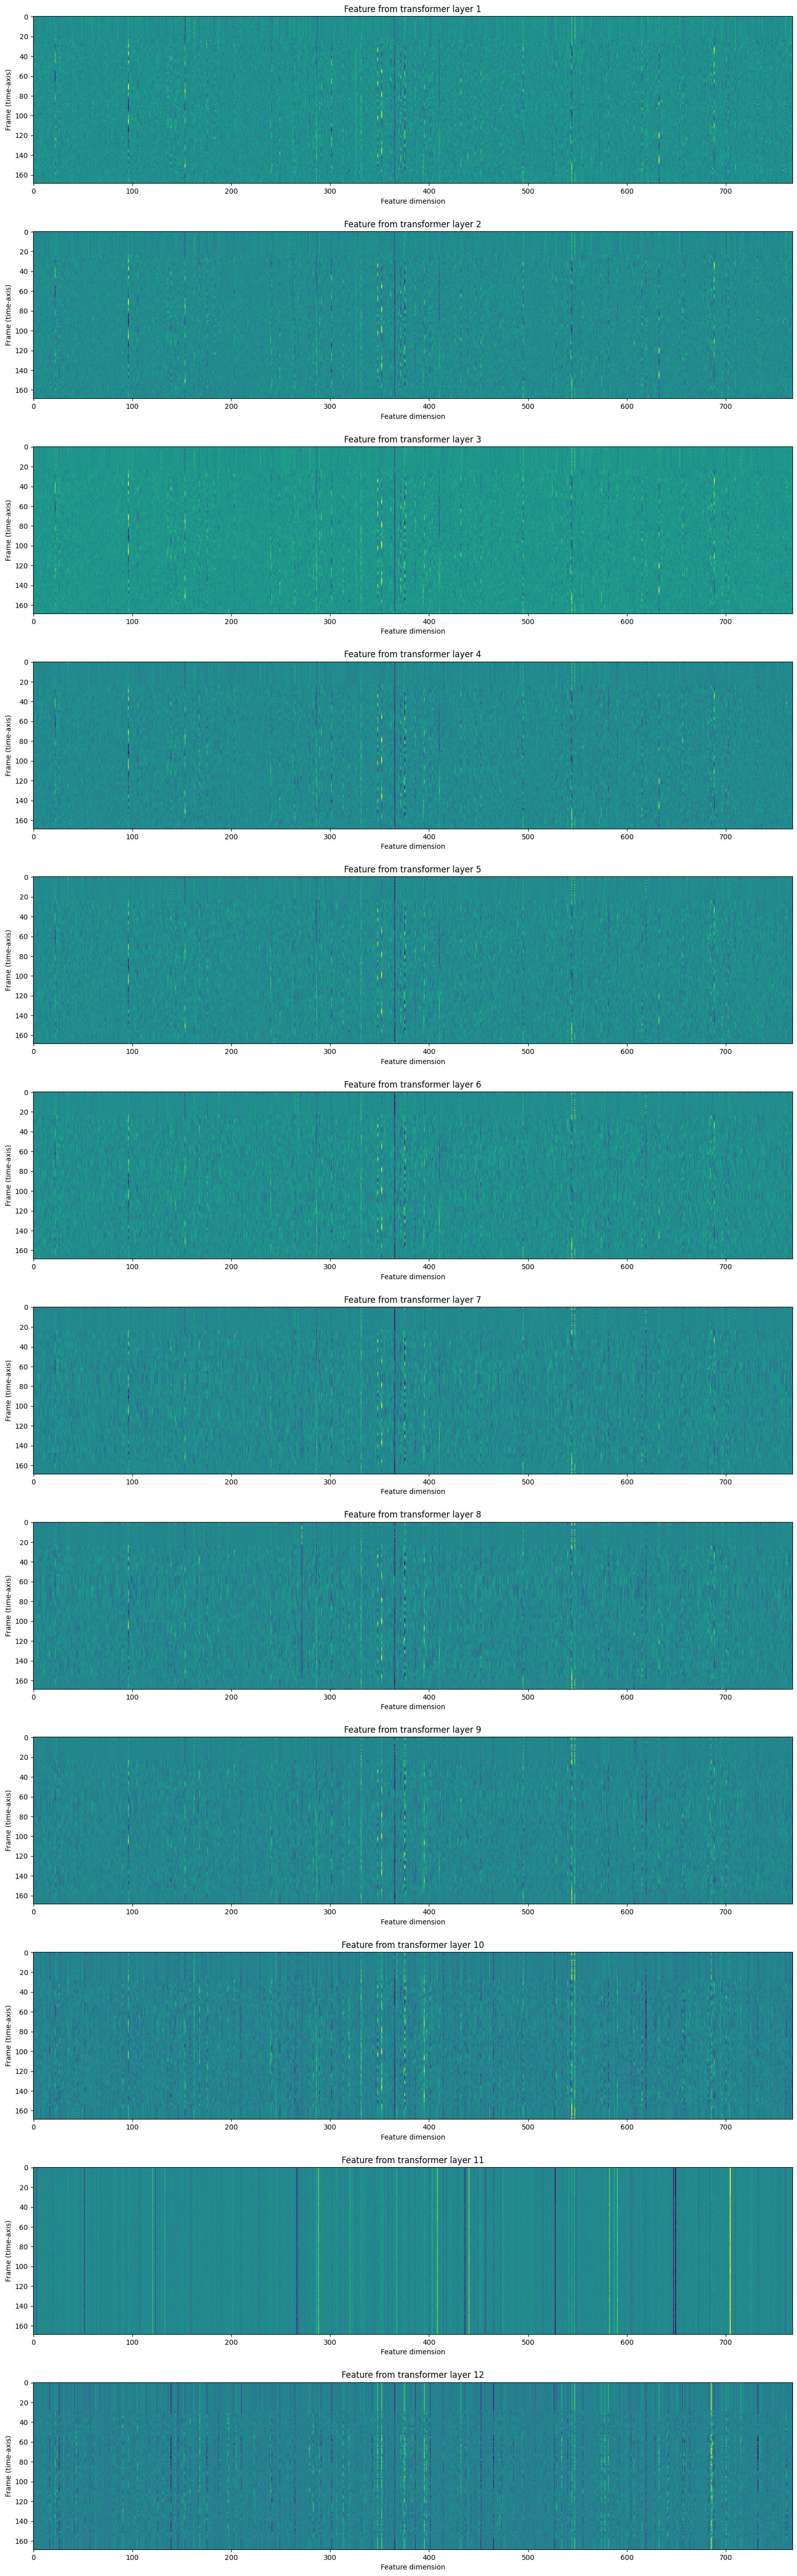

In [46]:
fig,ax = plt.subplots(len(features),1,figsize=(16,4.3*len(features)))
for i,feat in enumerate(features):
    ax[i].imshow(feat[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [55]:
features

AttributeError: 'list' object has no attribute 'shape'

In [79]:
with torch.inference_mode():
    predictions,_ = model(waveform)

In [80]:
predictions.shape

torch.Size([1, 661, 29])

In [61]:
bundle.get_labels()

('-',
 '|',
 'E',
 'T',
 'A',
 'O',
 'N',
 'I',
 'H',
 'S',
 'R',
 'D',
 'L',
 'U',
 'M',
 'W',
 'C',
 'F',
 'G',
 'Y',
 'P',
 'B',
 'V',
 'K',
 "'",
 'X',
 'J',
 'Q',
 'Z')

In [81]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self,labels,blank=0):
        super().__init__()
        self.labels=labels
        self.blank=blank

    def forward(self, emission: torch.Tensor):
        pred=torch.argmax(emission,dim=-1)
        pred=torch.unique_consecutive(pred)
        pred=[i for i in pred if i != self.blank]
        return "".join([self.labels[i] for i in pred])
    
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(predictions[0])
transcript

'WE|THE|PEOPLE|OF|THE|UNITED|STATES|IN|ORDER|TO|FORM|A|MORE|PERFECT|UNION|ESTARPLISH|JUSTICE|INSURE|DOMESTER|TRANQUILLITY|PROVIDE|FOR|THE|COMMON|DEFENCE|'

StreamLit

In [84]:
!pip3 install streamlit

In [85]:
import streamlit as st
st

<module 'streamlit' from '/Users/deependra/work/ML/SampleDockerPush/.venv/lib/python3.12/site-packages/streamlit/__init__.py'>

In [88]:
st.write("Hello, *World!* :sunglasses:")

2024-12-31 13:25:16.927 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-31 13:25:16.933 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-31 13:25:16.956 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-31 13:25:16.957 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [87]:
streamlit run /Users/deependra/work/ML/SampleDockerPush/.venv/lib/python3.12/site-packages/ipykernel_launcher.py 

SyntaxError: invalid syntax (283366040.py, line 1)